In [7]:
import numpy as np
import statsmodels
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


## Linear regression

Let’s go with the depression data. More toy datasets can be found here. For simplicity, I randomly picked 3 columns.

In [15]:
df = pd.read_csv('ginzberg_car.csv')
df = df[['adjdep','adjfatal','adjsimp']]
df['intercept'] = 1
df.head(2)

,adjdep,adjfatal,adjsimp,intercept
0,0.41865,0.10673,0.75934,1
1,0.51688,0.99915,0.72717,1


In [38]:
X = df.loc[:,['intercept','adjfatal','adjsimp']]
y = df.loc[:,'adjdep']
import statsmodels.formula.api as smf
reg = smf.OLS(y,X).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 adjdep   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     30.19
Date:                Wed, 29 May 2019   Prob (F-statistic):           1.82e-10
Time:                        23:15:47   Log-Likelihood:                -35.735
No. Observations:                  82   AIC:                             77.47
Df Residuals:                      79   BIC:                             84.69
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2492      0.105      2.365      0.021       0.039       0.459
adjfatal       0.3845      0.100      3.829      0.000       0.185       0.584
adjsimp        0.3663      0.100      3.649      0.000       0.166       0.566
==============================================================================
Omnibus:                       10.510   Durbin-Watson:                   1.178
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.561
Skew:                           0.836   Prob(JB):                      0.00509
Kurtosis:                       3.542   Cond. No.                         5.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression assumptions

### 1st Linearity & Equal variance

In [17]:
#Both can be tested by plotting residuals vs. predictions, where residuals are prediction errors.
pred_val = reg.fittedvalues.copy()
true_val = df['adjdep'].values.copy()
residual = true_val - pred_val

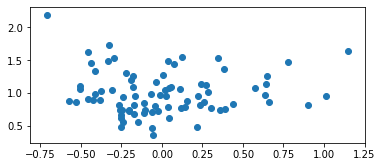

In [18]:
fig,ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(residual,pred_val)

It seems like the corresponding residual plot is reasonably random. To confirm that, let’s go with a hypothesis test, Harvey-Collier multiplier test, for linearity

In [19]:
import statsmodels.stats.api as sms
sms.linear_harvey_collier(reg)

Ttest_1sampResult(statistic=4.9902148829829125, pvalue=3.5816973971950396e-06)

Several tests exist for equal variance, with different alternative hypotheses. Let’s go with Breusch-Pagan test as an example. More can be found here. Small p-value (pval below) shows that there is violation of homoscedasticity.

In [20]:
_,pval,__,f_pval = statsmodels.stats.diagnostic.het_breuschpagan(residual,df[['adjfatal', 'adjsimp']])
pval,f_pval

(6.448482473014033e-08, 2.2130738396034907e-08)

Usually assumption violations are not independent of each other. Having one violations may lead to another. In this case, we see that both linearity and homoscedasticity are not met. Possible data transformation such as log, Box-Cox power transformation, and other fixes may be needed to get a better regression outcome.

### Normality

We can apply normal probability plot to assess how the data (error) depart from normality visually:

0.9523990893322949

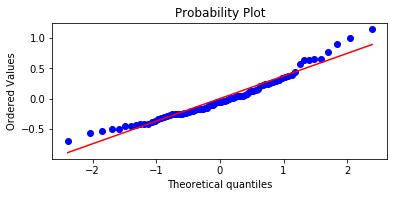

In [21]:
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
r**2

The good fit indicates that normality is a reasonable approximation.

### Box-Cox power transformation is used to fit linearity and homoscedasticity

In [34]:
from scipy import stats
X_bc = X.copy()
X_bc['adjfatal'],_ = stats.boxcox(X_bc['adjfatal']) 
X_bc['adjsimp'],_ = stats.boxcox(X_bc['adjsimp']) 

In [37]:
import statsmodels.formula.api as smf
reg_bc = smf.OLS(y,X_bc).fit()
reg_bc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 adjdep   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     31.61
Date:                Wed, 29 May 2019   Prob (F-statistic):           8.21e-11
Time:                        23:15:42   Log-Likelihood:                -34.907
No. Observations:                  82   AIC:                             75.81
Df Residuals:                      79   BIC:                             83.03
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0520      0.043     24.664      0.000       0.967       1.137
adjfatal       0.3708      0.094      3.939      0.000       0.183       0.558
adjsimp        0.3964      0.099      3.984      0.000       0.198       0.594
==============================================================================
Omnibus:                       11.310   Durbin-Watson:                   1.144
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.586
Skew:                           0.875   Prob(JB):                      0.00305
Kurtosis:                       3.574   Cond. No.                         2.88
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
pred_val_bc = reg_bc.fittedvalues.copy()
true_val_bc = df['adjdep'].values.copy()
residual_bc = true_val_bc - pred_val_bc

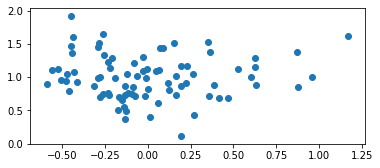

In [40]:
fig,ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(residual_bc,pred_val_bc)

In [41]:
import statsmodels.stats.api as sms
sms.linear_harvey_collier(reg_bc)

Ttest_1sampResult(statistic=5.186417200620418, pvalue=1.6485047147553297e-06)

In [42]:
_,pval,__,f_pval = statsmodels.stats.diagnostic.het_breuschpagan(residual_bc,X_bc[['adjfatal', 'adjsimp']])
pval,f_pval

(0.05867311810754846, 0.16816584993217856)

0.9459408967354266

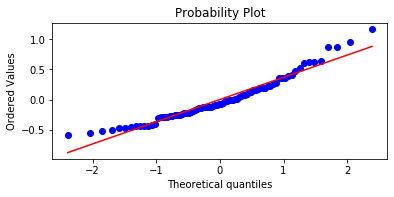

In [43]:
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual_bc, plot=ax, fit=True)
r**2